In [1]:
import logging
import numpy as np
import pandas as pd
# from arch import arch_model
from random import gauss
from random import seed
from matplotlib import pyplot as plt
import scipy.stats as sts
import json
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.optimize import least_squares
import os
from itertools import product
from pathlib import Path

In [2]:
_cur_dir = os.getcwd()
os.chdir('..')

In [3]:
from rules_related import combine_rules_outputs
from whole_algorithm import train_model
from auxiliary import calc_log_returns, unpack_1d_parameters
from multivariate_normal_distribution import LongMultivariateNormal
from model import FuzzyVolatilityModel
from membership_functions import calc_trapezoidal_membership_degrees
# from membership_functions.trapezoidal import _calc_trapezoidal_md_scalar

In [4]:
with open('config.json') as file:
    config = json.load(file)

In [5]:
INPUT = Path(config['files_folders']['processed'])
RES_DIR = Path(config['files_folders']['research_results'])
OUTPUT = Path(config['files_folders']['calculations_metaparams'])
LOGS_DIR = config['files_folders']['logs']

In [6]:
secs = ['rtsi']

# Main input data

In [7]:
_hist = {_sec: pd.read_pickle(INPUT / f'{_sec}.pkl') for _sec in secs}
hist = pd.concat(_hist).copy()
hist.index.names = ['sec', 'date']

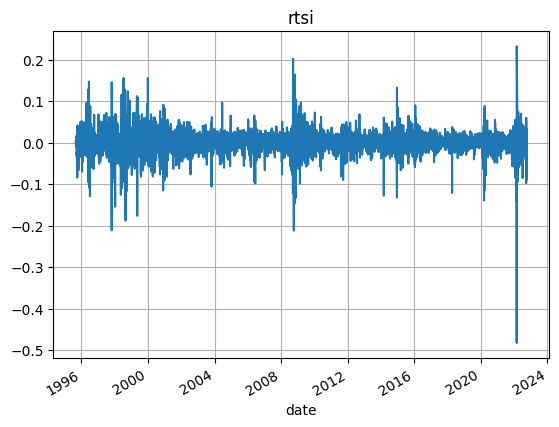

In [8]:
for sec in secs:
    hist.xs(sec)['log return'].plot()
    
    plt.title(sec)
    plt.grid()
    plt.show()

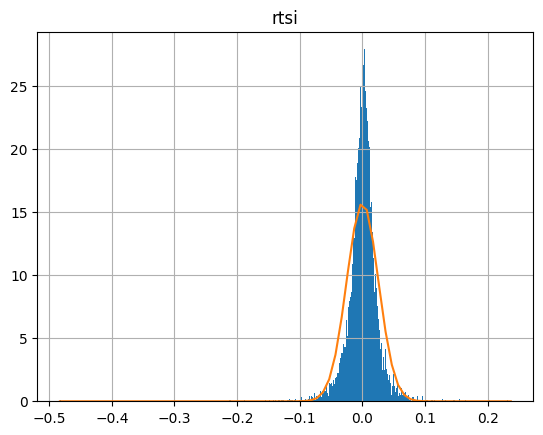

In [9]:
for sec in secs:
    _step = .01
    _ran = np.arange(hist.xs(sec)['log return'].min(), hist.xs(sec)['log return'].max() + _step, _step)
    _norm_pdf = sts.norm(loc=hist.xs(sec)['log return'].mean(), scale=hist.xs(sec)['log return'].std()).pdf(_ran)

    hist.xs(sec)['log return'].hist(bins=500, density=True)
    plt.plot(_ran, _norm_pdf)
    
    plt.title(sec)
    plt.show()

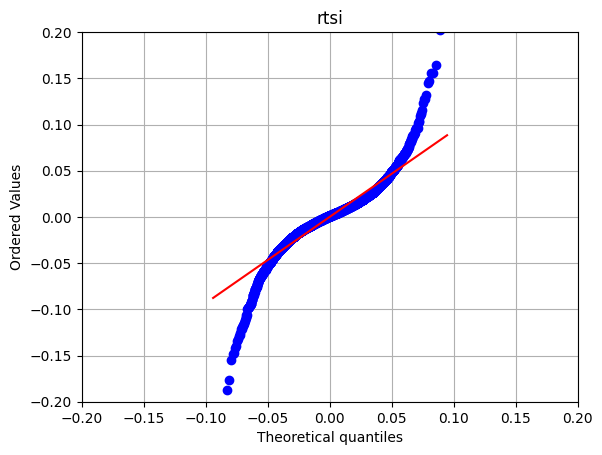

In [10]:
for sec in secs:
    sts.probplot(hist.xs(sec)['log return'], dist='norm', sparams=(hist.xs(sec)['log return'].mean(), hist.xs(sec)['log return'].std()), plot=plt)

    _lim = .2
    plt.xlim(-_lim, _lim)
    plt.ylim(-_lim, _lim)
    plt.title(sec)
    plt.grid()

In [11]:
hist.groupby('sec')['log return'].describe()

,count,mean,std,min,25%,50%,75%,max
sec,,,,,,,,
rtsi,6771.0,0.000354,0.025407,-0.482921,-0.010185,0.001224,0.011688,0.232044


In [12]:
for sec in secs:
    hist['day of week'] = hist.index.get_level_values('date').dayofweek + 1

In [13]:
hist['day of week'].value_counts()

3    1364
4    1361
2    1360
5    1340
1    1297
6      34
7      15
Name: day of week, dtype: int64

# Constants

In [14]:
rescale_factor = 1
start_dts = ['2018-01-01', '2015-01-01']
# end_date = '2020-12-31'
n_samples = [126, 252]  # 506 + 126

if len(n_samples) != len(start_dts):
    raise Exception('different number of start dates & samples lengths')

rets = {
    sec:
    [
        (hist.xs(sec)['log return'].loc[start_dt:].iloc[:n_sample].copy() * rescale_factor).copy()
        for start_dt, n_sample in zip(start_dts, n_samples)
    ]
}

rets = \
    pd.concat(
        {sec: pd.concat(_rets, axis='index', keys=np.arange(len(n_samples))) for sec, _rets in rets.items()},
        axis='index'
    ).copy()

rets.index.names = ['sec', 'sample #', 'date']

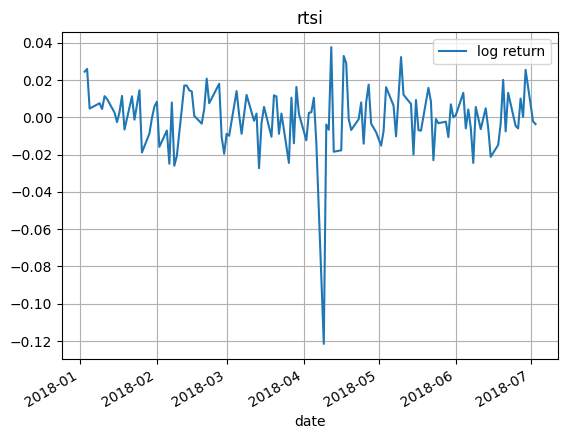

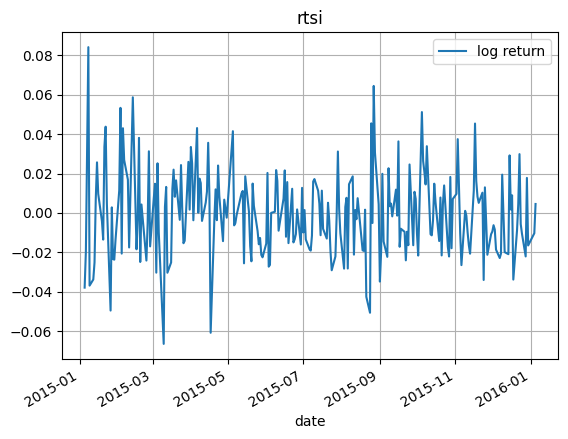

In [15]:
for sec in secs:
    _rets = rets.xs(sec)
    for i in _rets.index.get_level_values(0).unique():
        _rets.xs(i).plot(label='log return')
        
        plt.title(f'{sec}')
        plt.legend()
        plt.grid()
        plt.show()

In [16]:
rets.groupby(['sec', 'sample #']).describe()

count      mean       std       min       25%       50%  \
sec  sample #                                                            
rtsi 0         126.0 -0.000048  0.017172 -0.121533 -0.007505  0.000525   
     1         252.0 -0.000195  0.021713 -0.066458 -0.016099 -0.001238   

                    75%       max  
sec  sample #                      
rtsi 0         0.009986  0.037639  
     1         0.012398  0.084156

In [17]:
ns = rets.groupby(['sec', 'sample #']).apply(lambda _ser: _ser.shape[0]).copy()
ns

sec   sample #
rtsi  0           126
      1           252
Name: log return, dtype: int64

# Train / test split

In [18]:
n_trains = [1 for _ in range(len(start_dts))]

# n_test = 252
# n_test = min(n - n_train, n_test)
# train_end = '2019-12-31'

In [19]:
ret_trains = rets.groupby(['sec', 'sample #']).apply(lambda _ser: _ser.iloc[:n_trains[_ser.index[0][1]]]).copy()
ret_trains = ret_trains.droplevel([2, 3]).copy()

ret_tests = rets.groupby(['sec', 'sample #']).apply(lambda _ser: _ser.iloc[n_trains[_ser.index[0][1]]:]).copy()
ret_tests = ret_tests.droplevel([2, 3]).copy()

In [20]:
train_means = ret_trains.groupby(['sec', 'sample #']).mean().copy()

trains = \
    ret_trains.groupby(['sec', 'sample #']).apply(
        lambda _ser: _ser - train_means.loc[_ser.index[0][0], _ser.index[0][1]]
    ).copy()

tests = \
    ret_tests.groupby(['sec', 'sample #']).apply(
        lambda _ser:
        (_ser - _ser.expanding().mean()).iloc[n_trains[_ser.index[0][1]]:]
    ).copy()
tests = tests.droplevel([2, 3]).copy()

In [21]:
# ret_train, ret_test = ret.iloc[:n_train].copy(), ret.iloc[n_train:].copy()

# train_mean = ret_train.mean()
# train = (ret_train - train_mean).copy()
# test = (ret - ret.expanding().mean()).iloc[n_train:].copy()

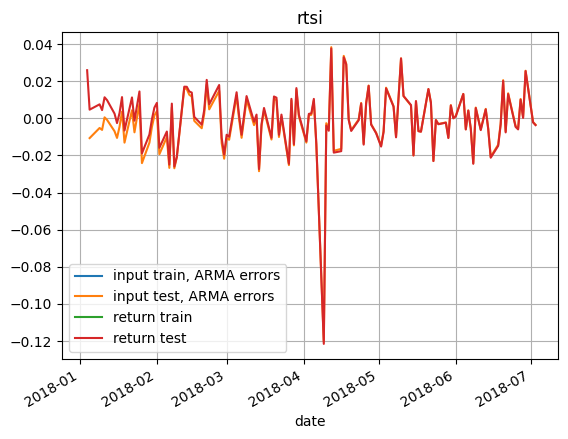

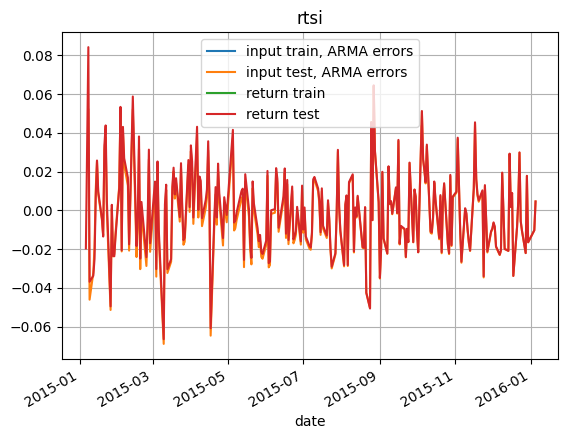

In [22]:
for sec in secs:
    _rets = rets.xs(sec)
    for i in _rets.index.get_level_values('sample #').unique():
        trains.xs(sec).xs(i).plot(label='input train, ARMA errors')
        tests.xs(sec).xs(i).plot(label='input test, ARMA errors')
        ret_trains.xs(sec).xs(i).plot(label='return train')
        ret_tests.xs(sec).xs(i).plot(label='return test')
        
        plt.title(sec)
        plt.legend()
        plt.grid()
        plt.show()

# Consequent

In [23]:
# general parameters
local_method = 'garch'

# GARCH hyperparameters
p = 1
q = 1

starting_index = max(p, q)

# train_sample_stds = trains.groupby(['sec', 'sample #']).std()
# first_h = [train_sample_std ** 2] * starting_index
# first_h = np.array(first_h)

# parameters constraints
lower_bounds = [0] * (1 + p + q)
upper_bounds = [+np.inf] + [1] * (p + q)
bounds = (lower_bounds, upper_bounds)

# consequent estimator params
rls_omega = 1e0

## initial parameters values

In [24]:
parameters_ini = {
    'alpha_0': np.array([0]),
    'alpha': np.array([[0]]),
    'beta': np.array([[0]])
}

## Setting dict w/ all consequent parameters

In [25]:
consequent_metaparams = {'p': p, 'q': q,  # 'first_h': first_h,
                         'bounds': bounds, 'parameters_ini': parameters_ini}

# Other params

In [26]:
data_to_cluster_trains = trains.to_frame()
data_to_cluster_tests = tests.to_frame().copy()

In [27]:
normalize = True

n_points_fitting = 10  # 252 * 2

optimization = 'ls'
optimization_parameters = {}

past_h_type = 'rule-wise'

# Antecedent parameters

In [28]:
variance = .02 * rescale_factor
n_clusters = 1
sigma = 0
potentials_focal = np.array([1] * n_clusters)
delta_min = variance * 1e-6

clusterization_parameters = {
    'n_clusters': n_clusters,
#     'centers': centers,
    'variance': variance,
    'sigma': sigma,
#     'beta': beta,
    'potentials_focal': potentials_focal,
    'delta_min': delta_min
}

## $h_t = \alpha_0 + \sum_{i = 1}^{q} \alpha_i y_{t - i}^2 + \sum_{j = 1}^{p} \beta_j h_{t - j}$

## $p = 1$, $q = 1$

## $x_t = (y_{t - 1}, h_{t - 1})$ or $x_t = (y_{t - 1})$

In [29]:
x_dim = q  # p + q + 1 is also possible (if output value y_t is also used for clustering)

centers = np.array([[0 for _ in range(q)]])
beta = np.array([0] * x_dim)

clusterization_parameters.update({
    'x_dim': x_dim,
    'centers': centers,
    'beta': beta
})

In [30]:
clusterization_method = 'eTS'
membership_function = 'gaussian'

In [31]:
n_last_points_to_use_for_clustering = None

# Antecedent-dependent consequent params

In [32]:
first_h_1d = [0] * starting_index
first_h = np.array([first_h_1d for _ in range(n_clusters)]).T.copy()

# Aggregating all data to one dict

In [33]:
metadata = []

for sec in secs:
    for sample_i in range(len(n_samples)):
        train = trains.xs(sec).xs(sample_i).copy()
        test = tests.xs(sec).xs(sample_i).copy()
        
        fvm_ini_params = {
            'train_data': train,
            'clusterization_method': clusterization_method,
            'membership_function': membership_function,
            'clusterization_parameters': clusterization_parameters,
            'local_method': local_method,
            'local_method_parameters': consequent_metaparams,
            'n_last_points_to_use_for_clustering': n_last_points_to_use_for_clustering,
            'data_to_cluster': data_to_cluster_trains.xs(sec).xs(sample_i),
            'normalize': normalize,
            'n_points_fitting': n_points_fitting,
            'first_h': first_h,
            'optimization': optimization,
            'optimization_parameters': optimization_parameters,
            'clustered_space_dim': x_dim,
            'past_h_type': past_h_type,
            'rls_omega': rls_omega
        }

        fvm_test_params = {
            'test_data': test,
            'data_to_cluster': data_to_cluster_tests.xs(sec).xs(sample_i)
        }

        _train_start = str(train.index[0]).split(' ')[0]
        _n_train = train.shape[0]
        _n_test = test.shape[0]
        _n_retrain = fvm_ini_params['n_points_fitting']
        _desc = {
            'series_name': sec,
            'train_start': _train_start,
            'n_train': _n_train,
            'n_test': _n_test,
            'n_retrain': _n_retrain,
            'M': n_last_points_to_use_for_clustering,
            'rescale_factor': rescale_factor
        }

        metadata_single_in = {
            'fvm_ini_params': fvm_ini_params,
            'fvm_test_params': fvm_test_params,
            '_desc': _desc
        }
        
        metadata.append(metadata_single_in)

In [34]:
metadata[0]['fvm_ini_params']['clusterization_parameters']

{'n_clusters': 1,
 'variance': 0.02,
 'sigma': 0,
 'potentials_focal': array([1]),
 'delta_min': 2e-08,
 'x_dim': 1,
 'centers': array([[0]]),
 'beta': array([0])}

# Dumping

In [35]:
_file_name_cur = f'current_fvm_{clusterization_method}_metadata_mul.pkl'

_cur_time = str(pd.Timestamp.now().floor('s'))
_str_desc = str(_desc).replace(':', '=').replace("""'""", '')
_file_name_hist = \
    f'hist_fvm_{clusterization_method}_metadata_mul_{_str_desc}_{_cur_time}.pkl'.replace(' ', '_').replace(':', '-')

with open(OUTPUT / _file_name_cur, 'wb') as _file:
    pickle.dump(metadata, _file)

with open(OUTPUT / _file_name_hist, 'wb') as _file:
    pickle.dump(metadata, _file)

_file_name_cur

'current_fvm_eTS_metadata_mul.pkl'